# Определение перспективного тарифа для телеком-компании

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжение предоставлены данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Необходимо проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Шаг 1. Откроем файл с данными и изучим общую информацию

In [5]:
# Подключим необходимые библиотеки для самостоятельной работы
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats as st
from math import ceil as math

### Прочтем наши файлы с данными и сохраним их в переменных.

In [6]:
calls = pd.read_csv('/datasets/calls.csv') # информация о звонках
internet = pd.read_csv('/datasets/internet.csv', index_col=0) # информация об интернет-сессиях
messages = pd.read_csv('/datasets/messages.csv') # информация о сообщениях
tariffs = pd.read_csv('/datasets/tariffs.csv') # информация о тарифах
users = pd.read_csv('/datasets/users.csv') # информация о пользователях

### Изучим данные с загруженных таблиц

#### Изучим датасет Calls

In [7]:
#Получим информацию с таблицы "Calls" методом info
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


***Таблица calls (информация о звонках):
<br> id — уникальный номер звонка
<br> call_date — дата звонка
<br> duration — длительность звонка в минутах
<br> user_id — идентификатор пользователя, сделавшего звонок***

In [8]:
#Выведем первые 5 строк таблицы calls
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [9]:
#Посмотрим на столбцы в таблице
calls.columns

Index(['id', 'call_date', 'duration', 'user_id'], dtype='object')

In [10]:
#проверим наличие пустых значений
calls.isnull().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [11]:
#Проверим наличие дубликатов
calls.duplicated().sum()

0

In [12]:
print('Количество звонков у которых длительность звонка менее 1 минуты: {}'.format(len(calls[calls.duration < 1])))

Количество звонков у которых длительность звонка менее 1 минуты: 47927


***Вывод по таблице Calls:***
<br> Необходимо изменить типы данных в столбцах id, call_date, user_id
<br> Пустых значений и дубликатов не имеется
47927 звонков было совершено продолжительностью менее 1мин. Все нули заменим на 1 и после поменяем тип на int.

#### Изучим датасет Internet

In [13]:
##Получим информацию с таблицы "Internet" методом info
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


***Таблица internet (информация об интернет-сессиях):
<br> id — уникальный номер сессии
<br> mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
<br> session_date — дата интернет-сессии
<br> user_id — идентификатор пользователя***

In [14]:
#Выведем первые 5 строк таблицы internet
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [15]:
#Посмотрим на столбцы в таблице "Internet"
internet.columns

Index(['id', 'mb_used', 'session_date', 'user_id'], dtype='object')

In [16]:
#Посчитаем количество пустых значений в таблице "Internet"
internet.isnull().sum()

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [17]:
#Посчитает количество дубликатов в таблице "Internet"
internet.duplicated().sum()

0

In [18]:
print('Количество сессий объема потраченного за сессию интернет-трафика менее 1 Мб: {}'.format(len(internet.query('mb_used < 1 '))))

Количество сессий объема потраченного за сессию интернет-трафика менее 1 Мб: 19699


***Вывод по таблице Internet:***
<br> Также нужно изменить типы данных в столбцах : id , session_date
<br> Пустых значений и дубликатов не имеется;
<br> Объём потраченного за сессию интернет-трафика указан в мегабайтах, в то время, как в тарифе в гигабайтах. Таким образом, если пользователь израсходует объем трафика, предоставленный тарифным планом, для анализа нам потребуется привести дополнительный объем трафика к гигабайтам, чтобы рассчитать стоимость;
<br> 19699 сессий имеют объём потраченного за сессию интернет-трафика менее 1 Мб. Если сессия зарегистрирована, значит трафик был, можно сделать предположение, что в этот день пользователь либо не выходил в интернет, либо уровень сигнала был очень низкий и система зафиксировала начало сессии, но из-за качества соединения абонент ей не смог воспользоваться и сессия закрылась с нулевым значением. Исходя из условий - оператор округляет вверх значения мегабайтов. Все нули заменим на 1 и после поменяем тип на int.

#### Изучим датасет Messages

In [19]:
#Получим информацию с таблицы "Messages" методом info
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


***Таблица messages (информация о сообщениях):
<br> id — уникальный номер сообщения
<br> message_date — дата сообщения
<br> user_id — идентификатор пользователя, отправившего сообщение***

In [20]:
#Выведем первые пять строк из таблицы "Messages"
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [21]:
#Посмотрим на столбцы из таблицы "Messages"
messages.columns

Index(['id', 'message_date', 'user_id'], dtype='object')

In [22]:
#Посчитаем количество пустых значений в таблице "Messages"
messages.isnull().sum()

id              0
message_date    0
user_id         0
dtype: int64

In [23]:
#Посчитаем количество дубликатов в таблице "Messages"
messages.duplicated().sum()

0

***Вывод по таблице Messages:***
<br> Изменить типы данных в столбце : id, message_date
<br> Пустых значений и дубликатов не имеется

#### Изучим датасет Tariffs

In [24]:
##Получим информацию с таблицы "Tariffs" методом info
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


***Таблица tariffs (информация о тарифах):
<br> tariff_name — название тарифа
<br> rub_monthly_fee — ежемесячная абонентская плата в рублях
<br> minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
<br> messages_included — количество сообщений в месяц, включённых в абонентскую плату
<br> mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
<br> rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
<br> rub_per_message — стоимость отправки сообщения сверх тарифного пакета
<br> rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)***

In [25]:
# Поменяем имя одного столбца
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

In [26]:
#Выведем первые пять строк таблицы "Tariffs"
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [27]:
#Посмотрим на столбцы из таблицы "Tariffs"
tariffs.columns

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff'],
      dtype='object')

In [28]:
#Посчитаем количество пустых значений в таблице "Tariffs"
tariffs.isnull().sum()

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff                   0
dtype: int64

In [29]:
#Посчитаем количество дубликатов в таблице "Tariffs"
tariffs.duplicated().sum()

0

***Вывод по таблице Tariffs:***
<br> Типы данных указаны верно. Изменять ничего не нужно
<br> Пустых значений и дубликатов не имеется

#### Изучим датасет Users

In [30]:
##Получим информацию с таблицы "Users" методом info
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


***Таблица users (информация о пользователях):
<br> user_id — уникальный идентификатор пользователя
<br> first_name — имя пользователя
<br> last_name — фамилия пользователя
<br> age — возраст пользователя (годы)
<br> reg_date — дата подключения тарифа (день, месяц, год)
<br> churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
<br> city — город проживания пользователя
<br> tariff — название тарифного плана***

In [31]:
#Выведем первые пять строк таблицы "Users"
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [32]:
#Посмотрим на столбцы таблицы "Users"
users.columns

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')

Более подробно изучим данные в столбцах таблицы Users

In [33]:
#Посмотрим на имеющиеся данные о возрасте. Сделаем выборку по количеству повторяющихся значений в столбце age (возраст)
# в порядке убывания
users['age'].value_counts()

53    14
42    14
63    13
71    13
64    13
73    12
21    12
40    12
39    11
47    11
29    11
26    11
37    11
41    10
36    10
58    10
45    10
70    10
52    10
51     9
27     9
48     9
50     9
28     9
30     9
24     9
20     9
19     9
56     9
23     9
68     9
66     9
65     9
69     8
62     8
60     8
44     8
55     8
25     7
43     7
67     7
35     7
74     7
32     7
31     7
46     7
75     6
54     6
59     6
18     6
33     5
34     5
38     5
22     5
72     5
49     4
57     4
61     3
Name: age, dtype: int64

In [34]:
#Посмотрим сколько пользователей какого тарифа мы имеем
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [35]:
#Посмотрим на столбец first_name. Сделаем выборку по количеству повторяющихся значений в столбце first_name (имя пользователя)
# в порядке убывания
users['first_name'].value_counts()

Радим       6
Леонид      5
Пётр        5
Всеволод    4
Алиса       4
           ..
Варлам      1
Руслана     1
Луиза       1
Глеб        1
Фаддей      1
Name: first_name, Length: 246, dtype: int64

In [36]:
#Посмотрим на столбец last_name. Сделаем выборку по количеству повторяющихся значений в столбце last_name (фамилия пользователя)
# в порядке убывания
users['last_name'].value_counts()

Андреенко     5
Аркадьев      3
Абашкина      3
Березина      3
Озерова       3
             ..
Тихомирова    1
Акимчин       1
Игнатьев      1
Абрашина      1
Синицын       1
Name: last_name, Length: 419, dtype: int64

In [37]:
#Посмотрим на столбец city. Сделаем выборку по количеству повторяющихся значений в столбце city (город проживания пользователя)
# в порядке убывания
users['city'].value_counts()

Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Подольск            1
Архангельск         1
Нижневартовск       1
Иваново             1
Химки               1
Name: city, Length: 76, dtype: int64

In [38]:
#Посчитаем количество пустых значений в таблице "users"
users.isnull().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Users - это дата с информацией о пользователях. Состоит из 8 столбцов и 500 строк. Пропущенные значения есть. У столбца churn_date есть 462 пропуска.Это столбец с датой прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных). Вполследствии можно заменить на 0.

In [39]:
users['churn_date'].value_counts()

2018-12-03    2
2018-12-09    2
2018-10-03    2
2018-12-21    2
2018-10-14    2
2018-09-02    1
2018-11-30    1
2018-12-24    1
2018-12-30    1
2018-11-21    1
2018-12-26    1
2018-11-16    1
2018-11-26    1
2018-10-04    1
2018-10-28    1
2018-11-22    1
2018-11-07    1
2018-12-14    1
2018-11-13    1
2018-12-16    1
2018-08-31    1
2018-09-27    1
2018-10-25    1
2018-10-27    1
2018-08-17    1
2018-12-20    1
2018-12-23    1
2018-11-27    1
2018-12-11    1
2018-09-26    1
2018-12-25    1
2018-10-05    1
2018-12-18    1
Name: churn_date, dtype: int64

In [40]:
users['reg_date'].value_counts()

2018-05-28    8
2018-04-03    5
2018-01-04    5
2018-10-05    5
2018-07-16    5
             ..
2018-07-01    1
2018-01-17    1
2018-11-27    1
2018-04-08    1
2018-08-31    1
Name: reg_date, Length: 270, dtype: int64

In [41]:
#Посчитаем количество дубликатов таблицы "Users"
users.duplicated().sum()

0

***Вывод по таблице Users:***
<br> Изменить типы данных в : churn_date, reg_date,
<br> Имеются пустые значения в столбце churn_date.
<br> Дубликатов нет.

***Вывод по шагу №1:***
<br> Нам доступны данные 500 пользователей, 462 из которых все еще пользуются тарифом:
<br> 351 – Смарт
<br> 149 – Ультра
<br> Проблема 1 с таблицей calls: в duration нужно обработать 0 значения, с округлением в большую сторону (т.к. по условию 1 секунда разговора = целой минуте);
<br> Проблема 2 с таблицей calls: поменять формат времени call_date на datetime;
<br> Проблемы 3 с таблицей internet: в mb_used нужно обработать 0 значения, исправить формат времени session_date на datetime;
<br> Проблемы 4 с таблицей messages: поменять формат времени message_date на datetime;
<br> Проблемы 5 с таблицей users: обработать столбец churn_date (из условия если значение пропущено, то тариф ещё действовал на момент выгрузки данных). Также сделать user_id index'ом этой таблицы.

## Шаг 2. Предобработка данных

### Восстановим пропуски

In [42]:
# Звонки
calls['duration'] = calls['duration'].apply(np.ceil)
calls.loc[calls['duration'] == 0 ,'duration'] = 1
# Интернет-сессии
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

In [43]:
dtformat = '%Y-%m-%d'

def to_datetime(df, columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col], format=dtformat)

# Даты
to_datetime(users, ['reg_date', 'churn_date'])
to_datetime(calls, ['call_date'])
to_datetime(messages, ['message_date'])
to_datetime(internet, ['session_date'])
# Минуты и мегабайты
calls['duration'] = calls['duration'].astype('int64')
internet['mb_used'] = internet['mb_used'].astype('int64')

In [44]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [45]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


In [46]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [47]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null int64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.7+ MB


Посчитаем значения, необходимые для анализа каждого пользователя

In [48]:
users_costs = pd.DataFrame()

In [49]:
print(users['reg_date'].min(), users['reg_date'].max())
print(calls['call_date'].min(), calls['call_date'].max())
print(messages['message_date'].min(), messages['message_date'].max())
print(internet['session_date'].min(), internet['session_date'].max())

2018-01-01 00:00:00 2018-12-31 00:00:00
2018-01-01 00:00:00 2018-12-31 00:00:00
2018-01-02 00:00:00 2018-12-31 00:00:00
2018-01-01 00:00:00 2018-12-31 00:00:00


По данным получается что охватывается весь 2018 год. Значит рассматриваемый период - 12 месяцев.

In [50]:
users_costs = pd.DataFrame().astype('datetime64[M]')

Количество сделанных звонков и израсходованных минут разговора по месяцам

In [51]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

calls_in_month = calls.pivot_table(
    index=['month', 'user_id'],
    values='duration',
    aggfunc=['count', 'sum']
)

temp = pd.DataFrame(calls_in_month.to_records())

users_costs['user_id'] = temp['user_id']
users_costs['month']   = temp['month']
users_costs['calls']   = temp.iloc[:, 2]
users_costs['minutes'] = temp.iloc[:, 3]
print(calls.head())

       id  call_date  duration  user_id  month
0  1000_0 2018-07-25         1     1000      7
1  1000_1 2018-08-17         1     1000      8
2  1000_2 2018-06-11         3     1000      6
3  1000_3 2018-09-21        14     1000      9
4  1000_4 2018-12-15         6     1000     12


Количество отправленных сообщений по месяцам

In [52]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

messages_in_month = messages.pivot_table(
    index=['month', 'user_id'],
    values='id',
    aggfunc='count'
)

temp = pd.DataFrame(messages_in_month.to_records()).rename(columns={'id': 'messages'})

users_costs = users_costs.merge(temp, on=['user_id', 'month'], how='outer')
print(messages.head())

       id message_date  user_id  month
0  1000_0   2018-06-27     1000      6
1  1000_1   2018-10-08     1000     10
2  1000_2   2018-08-04     1000      8
3  1000_3   2018-06-16     1000      6
4  1000_4   2018-12-05     1000     12


Объем израсходованного интернет-трафика по месяцам

In [53]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

internet_in_month = internet.pivot_table(
    index=['month', 'user_id'],
    values='mb_used',
    aggfunc='sum'
)

temp = pd.DataFrame(internet_in_month.to_records())

users_costs = users_costs.merge(temp, on=['user_id', 'month'], how='outer')
print(internet.head())

       id  mb_used session_date  user_id  month
0  1000_0      113   2018-11-25     1000     11
1  1000_1     1053   2018-09-07     1000      9
2  1000_2     1198   2018-06-25     1000      6
3  1000_3      551   2018-08-22     1000      8
4  1000_4      303   2018-09-24     1000      9


In [54]:
users_costs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id     3214 non-null int64
month       3214 non-null int64
calls       3174 non-null float64
minutes     3174 non-null float64
messages    2717 non-null float64
mb_used     3203 non-null float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


***Вывод по шагу 2.1:***
<br> В одном датафрейме собрал информацию по пользователям в разрезе месяцев:
<br> * количество сделанных звонков и израсходованных минут разговора;
<br> * количество отправленных сообщений;
<br> * объем израсходованного интернет-трафика в мегабайтах.

### Замена пропусков

После формирования датафрейма по месяцам появились пропуски. Некоторые пользователи в некоторые месяцы пользовались не всеми услугами. Например, кто-то только мобильным интернетом. Заполним пропуски нулями и позже посмотрим на распределение.

In [55]:
na_features = ['calls', 'minutes', 'messages', 'mb_used']

for f in na_features:
    # При соединении датафреймов Pandas привел типы к float64 из-за пропусков,поэтому приведем их к int64
    users_costs[f] = users_costs[f].fillna(0).astype('int64')

In [56]:
users_costs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id     3214 non-null int64
month       3214 non-null int64
calls       3214 non-null int64
minutes     3214 non-null int64
messages    3214 non-null int64
mb_used     3214 non-null int64
dtypes: int64(6)
memory usage: 175.8 KB


In [57]:
users_costs.head()

,user_id,month,calls,minutes,messages,mb_used
0,1005,1,15,99,7,2730
1,1032,1,61,397,38,24147
2,1045,1,1,9,5,2348
3,1055,1,64,568,30,17111
4,1071,1,24,200,16,15622


***Вывод по шагу 2.2:***
<br> Убрал пропуски, изменил тип данных.

### Помесячная выручка с каждого пользователя

In [58]:
# Добавим в датафрейм информацию о пользователях и тарифах
users_costs = users_costs.merge(users, on='user_id', how='left').merge(tariffs, on='tariff', how='left')

In [59]:
# Перерасход минут, сообщений и трафика посчитаем как разность между месячным значением и включенным в тариф
users_costs['minutes_over']  = users_costs['minutes'] - users_costs['minutes_included']
users_costs['messages_over'] = users_costs['messages'] - users_costs['messages_included']
users_costs['mb_used_over']  = users_costs['mb_used'] - users_costs['mb_per_month_included']

In [60]:
users_costs.head()

,user_id,month,calls,minutes,messages,mb_used,age,churn_date,city,first_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_over,messages_over,mb_used_over
0,1005,1,15,99,7,2730,67,NaT,Набережные Челны,Афанасий,...,50,15360,500,550,200,3,3,-401,-43,-12630
1,1032,1,61,397,38,24147,31,NaT,Ульяновск,Инна,...,50,15360,500,550,200,3,3,-103,-12,8787
2,1045,1,1,9,5,2348,48,NaT,Улан-Удэ,Джемма,...,50,15360,500,550,200,3,3,-491,-45,-13012
3,1055,1,64,568,30,17111,39,NaT,Казань,Луиза,...,50,15360,500,550,200,3,3,68,-20,1751
4,1071,1,24,200,16,15622,20,2018-08-31,Омск,Гектор,...,50,15360,500,550,200,3,3,-300,-34,262


Положительные значения указывают на перерасход. Отрицательные на остаток в рамках тарифа.

In [61]:
def calc_monthly_finance(row):
    """
    Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика,
    остаток умножим на значение из тарифного плана.
    """
    
    minutes_price = 0
    messages_price = 0
    mb_used_price = 0
    
    # стоимость дополнительных минут
    if row['minutes_over'] > 0:
        minutes_price = row['minutes_over'] * row['rub_per_minute']

    # стоимость дополнительных сообщений
    if row['messages_over'] > 0:
        messages_price = row['messages_over'] * row['rub_per_message']

    # стоимость дополнительного трафика
    if row['mb_used_over'] > 0:
        mb_used_price = (row['mb_used_over'] / 1024) * row['rub_per_gb']
    
    return minutes_price + messages_price + mb_used_price

In [62]:
calc_monthly_finance.__doc__

'\n    Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика,\n    остаток умножим на значение из тарифного плана.\n    '

In [63]:
users_costs['rub_monthly_fee_over'] = users_costs.apply(calc_monthly_finance, axis=1)
users_costs['rub_monthly_fee_total'] = users_costs['rub_monthly_fee'] + users_costs['rub_monthly_fee_over']

In [64]:
users_costs.head()

,user_id,month,calls,minutes,messages,mb_used,age,churn_date,city,first_name,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_over,messages_over,mb_used_over,rub_monthly_fee_over,rub_monthly_fee_total
0,1005,1,15,99,7,2730,67,NaT,Набережные Челны,Афанасий,...,500,550,200,3,3,-401,-43,-12630,0.000000,550.000000
1,1032,1,61,397,38,24147,31,NaT,Ульяновск,Инна,...,500,550,200,3,3,-103,-12,8787,1716.210938,2266.210938
2,1045,1,1,9,5,2348,48,NaT,Улан-Удэ,Джемма,...,500,550,200,3,3,-491,-45,-13012,0.000000,550.000000
3,1055,1,64,568,30,17111,39,NaT,Казань,Луиза,...,500,550,200,3,3,68,-20,1751,545.992188,1095.992188
4,1071,1,24,200,16,15622,20,2018-08-31,Омск,Гектор,...,500,550,200,3,3,-300,-34,262,51.171875,601.171875


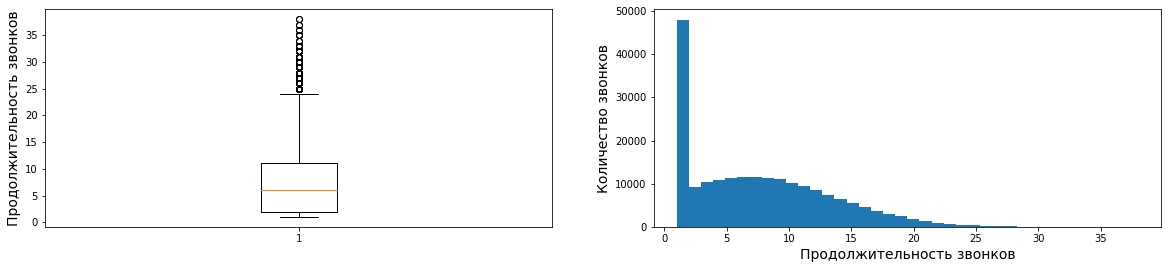

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,4))

ax1.boxplot(calls['duration'])
ax1.set_ylabel('Продолжительность звонков', fontsize=14)

ax2.hist(calls['duration'], bins=round(calls['duration'].max()))
ax2.set_xlabel('Продолжительность звонков', fontsize=14)
ax2.set_ylabel('Количество звонков', fontsize=14)

plt.show()

*Боксплот показал звонки длительностью 30мин и более. Считаю от этих выбросов не стоит избавляться, потому что звонок длиной в 30 минут вполне реален и необходимо его учитывать при расчете итоговой стоимости. По гистограмме видно, что больше всего звонков продолжительностью около 5 - 9 мин.*

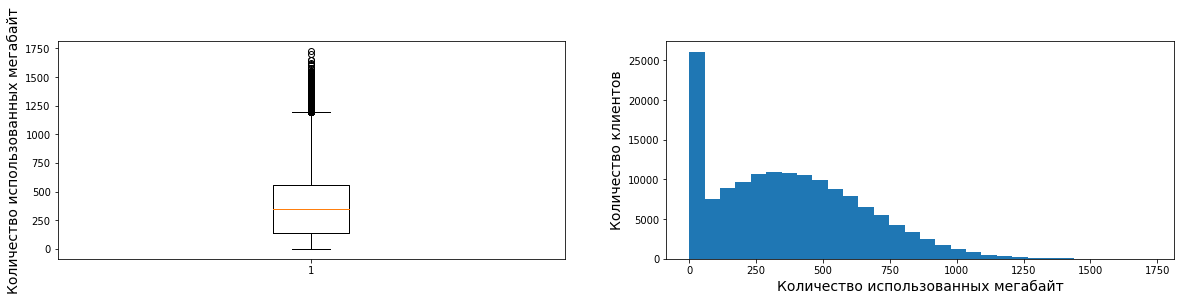

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,4))

ax1.boxplot(internet['mb_used'])
ax1.set_ylabel('Количество использованных мегабайт', fontsize=14)

ax2.hist(internet['mb_used'], bins=30)
ax2.set_xlabel('Количество использованных мегабайт', fontsize=14)
ax2.set_ylabel('Количество клиентов', fontsize=14)

plt.show()

*Боксплот указал на количество использованного траффика более 1250Мб, эти выбросы также оставляем в работе. По гистограмме видно, что больше всего траффика используется в интервале 300-400Мб.*

In [67]:
smart = users_costs.query("tariff == 'smart'")

In [68]:
print('Количество пользователей смарт: {}'.format(len(smart.groupby('user_id'))))

Количество пользователей смарт: 350


In [69]:
ultra = users_costs.query("tariff == 'ultra'")

In [70]:
print('Количество пользователей юльтра: {}'.format(len(ultra.groupby('user_id'))))

Количество пользователей юльтра: 148


***Вывод по шагу 2.3:***
<br> * данные без пропусков собрал в итоговую таблицу для анализа;
<br> * пользователей тарифа "Смарт" - 350, тарифа "Ультра" - 148.

## Шаг 3. Статистический анализ данных

### Опишем поведение клиентов оператора, исходя из выборки.

In [71]:
#Передадим переменным smart_tariff и ultra_tariff соответственные данные из таблицы
smart_tariff = users_costs[users_costs['tariff']=='smart']
ultra_tariff = users_costs[users_costs['tariff']=='ultra']

In [72]:
smart = users[users['tariff']=='smart']
ultra = users[users['tariff']=='ultra']

print('Количество клиентов с тарифом Ультра: {}'.format(ultra['tariff'].count()))
print('Количество клиентов с тарифом Смарт: {}\n'.format(smart['tariff'].count()))
print('В среднем один пользователь тарифа Ультра приносит: {:.0f} рублей'.format(ultra_tariff['rub_monthly_fee_total'].sum()/ultra['tariff'].count()))
print('В среднем один пользователь тарифа Смарт приносит: {:.0f} рублей\n'.format(smart_tariff['rub_monthly_fee_total'].sum()/smart['tariff'].count()))
print('Годавая прибыль по тарифу Ультра: {:.0f} рублей'.format(ultra_tariff['rub_monthly_fee_total'].sum()))
print('Годовая прибыль по тарифу Смарт: {:.0f} рублей\n'.format(smart_tariff['rub_monthly_fee_total'].sum()))

Количество клиентов с тарифом Ультра: 149
Количество клиентов с тарифом Смарт: 351

В среднем один пользователь тарифа Ультра приносит: 13622 рублей
В среднем один пользователь тарифа Смарт приносит: 7940 рублей

Годавая прибыль по тарифу Ультра: 2029622 рублей
Годовая прибыль по тарифу Смарт: 2786975 рублей



In [73]:
values = ['minutes', 'messages', 'mb_used', 'rub_monthly_fee_over', 'rub_monthly_fee_total']

# Сделаем сводную таблицу по тарифам в разрезе месяцев
tariff_monthly_users_costs = users_costs.pivot_table(
    index=['tariff', 'month'],
    values=values
)

In [74]:
smart_monthly_costs = tariff_monthly_users_costs.loc['smart']
smart_monthly_costs

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
month,,,,,
1,8524.441176,18.235294,209.647059,154.585708,704.585708
2,11611.396552,24.086207,306.310345,261.785964,811.785964
3,15123.857143,31.857143,400.532468,582.330560,1132.330560
4,13479.482143,30.741071,377.000000,384.126186,934.126186
5,15825.198582,33.773050,398.404255,610.007037,1160.007037
6,15814.768293,33.402439,406.701220,613.610185,1163.610185
7,15763.512438,33.751244,419.288557,634.615905,1184.615905
8,16632.174468,33.638298,433.191489,725.515027,1275.515027
9,16324.526923,33.638462,440.080769,666.703275,1216.703275


In [75]:
ultra_monthly_costs = tariff_monthly_users_costs.loc['ultra']
ultra_monthly_costs

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
month,,,,,
1,13153.555556,33.777778,440.888889,0.000000,1950.000000
2,11786.958333,21.958333,304.666667,23.046875,1973.046875
3,17551.972973,32.297297,503.081081,54.171505,2004.171505
4,16843.800000,31.563636,470.072727,45.431463,1995.431463
5,19381.194030,37.850746,524.865672,104.965893,2054.965893
6,18942.238095,41.726190,492.428571,82.060896,2032.060896
7,20514.648352,49.846154,560.296703,158.502533,2108.502533
8,19594.065421,48.439252,524.570093,121.152161,2071.152161
9,19222.208696,52.286957,553.643478,63.725798,2013.725798


Минуты разговора, количество сообщений и объём интернет-трафика в среднем необходимые пользователям каждого тарифа в месяц

In [76]:
tariff_usage = tariff_monthly_users_costs.pivot_table(
    index='tariff',
    values=values
)
tariff_usage

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
tariff,,,,,
smart,15077.690651,31.413211,397.374228,594.741849,1144.741849
ultra,18222.784561,43.714983,509.356551,88.917311,2038.917311


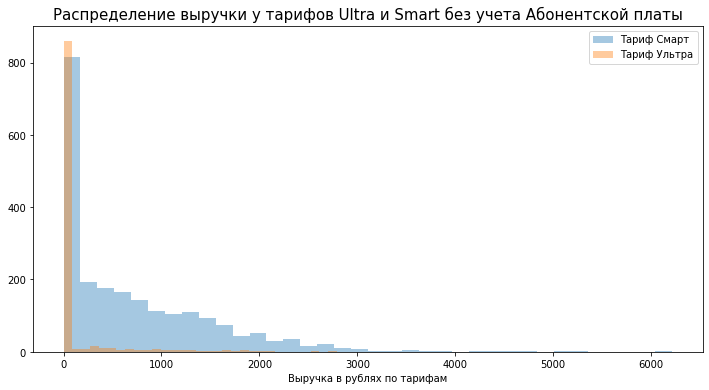

In [77]:
#Построим два графика по прибыли без учета абон платы
plt.figure(figsize=(12,6))
plt.title('Распределение выручки у тарифов Ultra и Smart без учета Абонентской платы', fontsize=15)
ax = sns.distplot(a=smart_tariff['rub_monthly_fee_total']-550, label='Тариф Смарт', kde=False)
ax = sns.distplot(a=ultra_tariff['rub_monthly_fee_total']-1950, label='Тариф Ультра', kde=False)
ax.set(xlabel='Выручка в рублях по тарифам')
plt.legend()

Пользователи тарифа Смарт больше всего оплачивают сверх абонентской платы. Пользователям тарифа Ультра достаточно пакета с имеющимися минутами и мегабайтами.

***Вывод по шагу 3.1:***
<br> * Пользователи тарифа Ультра более активны почти по всем позициям (длительность звонков, количество сообщений и объём интернет-трафика), но пользователи тарифа Смарт тратят в 6 раз больше на дополнительные пакеты услуг;
<br> * Для оператора прибыльным тарифом является тариф Ультра, даже с учетом того, что в среднем пользователи не выходят за границы тарифных лимитов, а пользователи тарифа Смарт не тратят столько денег, чтобы перегнать стоимость тарифа Ультра. Таким образом, для пользователя выгоднее тариф Смарт;
<br> * Rаждый пользователь тарифа Ультра приносит компании в среднем 13 622 рублей в год, пользователь тарифа Смарт приносит лишь 7940 рублей в год;
<br> * Годовая выручка компании по тарифу Смарт - 2 786 975 рублей в год, по тарифу Ультра приносит 2 029 622 рублей в год.

### Среднее количество, дисперсия и стандартное отклонение

Определяем среднее количество, дисперсию и стандартное отклонение по продолжительности звонков на тарифах "Смарт" и "Ультра" в минутах разговора

In [78]:
#Посчитаем среднее, медиану, дисперсию и среднее отклонение для тарифа Smart
for column in smart_tariff[['minutes','messages','mb_used','rub_monthly_fee_total']]:
    print('Среднее {}: {:.0f}'.format(column,smart_tariff[column].mean()))
    print('Медиана {}: {:.0f}'.format(column,smart_tariff[column].median()))
    print('Дисперсия {}: {:.0f}'.format(column,np.var(smart_tariff[column])))
    print('Среднее отклонение {}: {:.0f} \n'.format(column, np.std(smart_tariff[column])))

Среднее minutes: 429
Медиана minutes: 435
Дисперсия minutes: 37958
Среднее отклонение minutes: 195 

Среднее messages: 33
Медиана messages: 28
Дисперсия messages: 796
Среднее отклонение messages: 28 

Среднее mb_used: 16229
Медиана mb_used: 16531
Дисперсия mb_used: 34530413
Среднее отклонение mb_used: 5876 

Среднее rub_monthly_fee_total: 1250
Медиана rub_monthly_fee_total: 986
Дисперсия rub_monthly_fee_total: 634974
Среднее отклонение rub_monthly_fee_total: 797 



In [79]:
#Посчитаем среднее, медиану, дисперсию и среднее отклонение для тарифа Ultra
for column in ultra_tariff[['minutes','messages','mb_used','rub_monthly_fee_total']]:    
    print('Среднее {}: {:.0f}'.format(column,ultra_tariff[column].mean()))
    print('Медиана {}: {:.0f}'.format(column,ultra_tariff[column].median()))
    print('Дисперсия {}: {:.0f}'.format(column,np.var(ultra_tariff[column])))
    print('Среднее отклонение {}: {:.0f} \n'.format(column, np.std(ultra_tariff[column])))

Среднее minutes: 541
Медиана minutes: 532
Дисперсия minutes: 105998
Среднее отклонение minutes: 326 

Среднее messages: 49
Медиана messages: 38
Дисперсия messages: 2283
Среднее отклонение messages: 48 

Среднее mb_used: 19487
Медиана mb_used: 19324
Дисперсия mb_used: 101832133
Среднее отклонение mb_used: 10091 

Среднее rub_monthly_fee_total: 2061
Медиана rub_monthly_fee_total: 1950
Дисперсия rub_monthly_fee_total: 126824
Среднее отклонение rub_monthly_fee_total: 356 



<br> * Оптимальным количеством сообщений для пользователей тарифа ультра можно установить в 49 (среднее значение) + 48 (стандартное отклонение)*3 = 49 + 144 = 193, то есть оптимальным будет установить тариф в 200 сообщений.
<br> * Для тарифа смарт оптимальное количество сообщений, нужное для пользователей: 33 (среднее значение) + 28 (стандартное отклонение)*3 = 33 + 84 = 117 сообщений является оптимальным для пользователей смарт, то есть можно округлить либо до 110, либо до 120, чтобы покрыть нужды всех пользователей.
<br> * 200 для УЛЬТРА требуется сообщений в месяц.
<br> * 120 для СМАРТ требуется сообщений в месяц.
<br> * Тем самым для тарифа ультра можно уменьшить тарифный план, а для смарт увеличить.

<br> * Оптимальным количеством звонков для пользователей тарифа ультра можно установить в 541 (среднее значение) + 326 (стандартное отклонение)*3 = 541 + 978 = 1519 минут разговора для пользователей ультра, то есть оптимальным будет 1550 минут.
<br> * Для тарифа смарт оптимальное количество звонков, нужное для пользователей:: 432 (среднее значение) + 192 (стандартное отклонение)*3 = 429 + 585 = 1014 минут разговора для пользователей смарта. То есть можно округлить до 1000 минут в месяц.
<br> * 1550 для УЛЬТРА требуется минут разговора в месяц.
<br> * 1000 для СМАРТ требуется минут разговора в месяц.

<br> * Оптимальным количеством трафика для пользователей тарифа ультра можно установить в 19487 (среднее значение) + 10091 (стандартное отклонение)*3 = 19487 + 30273 = 49760 мб интернет-трафика для пользователей ультра, то есть оптимальным будет 1550 будет 50 гб.
<br> * Для тарифа смарт оптимальное количество звонков, нужное для пользователей: 16229 (среднее значение) + 5876 (стандартное отклонение)*3 = 16229 + 17628 = 33857 мб интернет-трафика для пользователей смарта, то есть оптимальным тарифным планом для интернета будет 32 гб.
<br> * 50 для УЛЬТРА требуется гб интернет трафика в месяц
<br> * 32 для СМАРТ требуется гб интернет трафика в месяц

Построим гистограммы и опишем распределения

In [80]:
#Напишем функцию для построения гистограмм
def histogram_drawing(column, title):
    sns.set_style('darkgrid')
    plt.figure(figsize=(12,6))
    plt.title(title, fontsize=15)
    sns.distplot(smart_tariff[column], label='Тариф Smart', kde=False)
    sns.distplot(ultra_tariff[column], label='Тариф Ultra', kde=False)
    plt.axvline(np.mean(smart_tariff[column]),color='g', linestyle='--', label='Smart среднее')
    plt.axvline(np.mean(ultra_tariff[column]),color='g', linestyle='-', label='Ultra среднее')
    plt.legend()

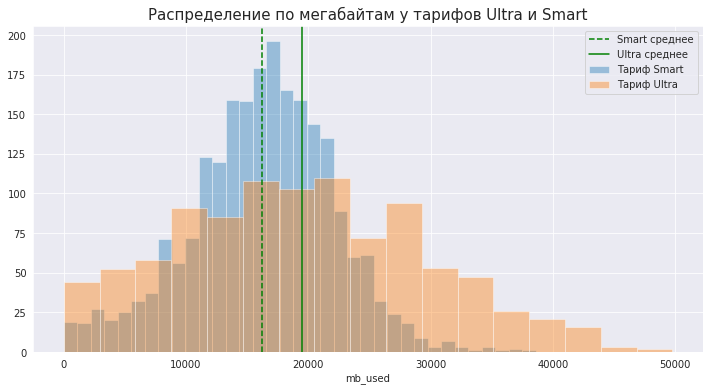

In [81]:
#Построим гистограммы для mb_used тарифов ultra и smart
histogram_drawing('mb_used', 'Распределение по мегабайтам у тарифов Ultra и Smart')

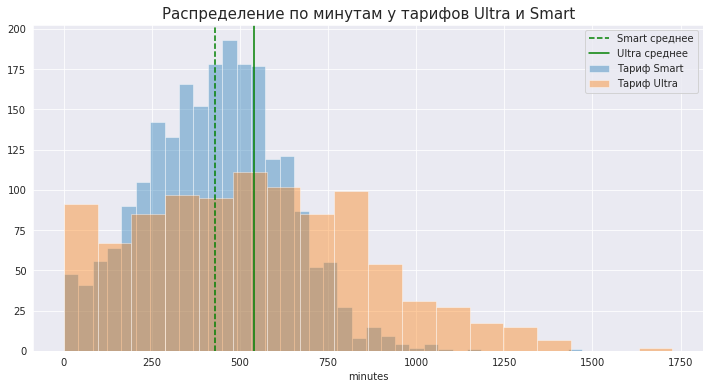

In [82]:
#Построим гистограммы для minutes тарифов ultra и smart
histogram_drawing('minutes','Распределение по минутам у тарифов Ultra и Smart')

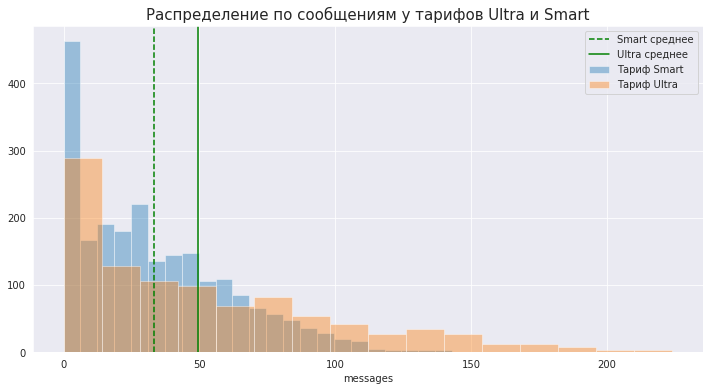

In [83]:
#Построим гистограммы для messages тарифов ultra и smart
histogram_drawing('messages','Распределение по сообщениям у тарифов Ultra и Smart')

По гистограммам видно, что дисперсия по тарифу "Смарт" меньше, чем у пользователей с тарифом "Ультра" по всем показателям: по длительности разговора, числу сообщений и использованному интернет-трафику. На всех гистограммах тариф "Ультра" имеет датасет с положительной скошенностью. На гистограммах "Распределение по минутам у тарифов Ultra и Smart" и "Распределение по мегабайтам у тарифов Ultra и Smart" тариф "Smart"имеет датасет с отрицательной скошенностью. На гистограмме "Распределение по сообщениям у тарифов Ultra и Smart" тариф "Smart" имеет датасет с положительной скошенностью. Скошенностью понимают, что дополнительные значения находятся со стороны положительного или отрицательного направления оси.
Другими словами, поведение пользователей тарифа "Ультра" более разнообразное с точки зрения потребления услуг. Пользователи тарифа "Ультра" более свободны в выборе того, как именно использовать объемы тарифного пакета.

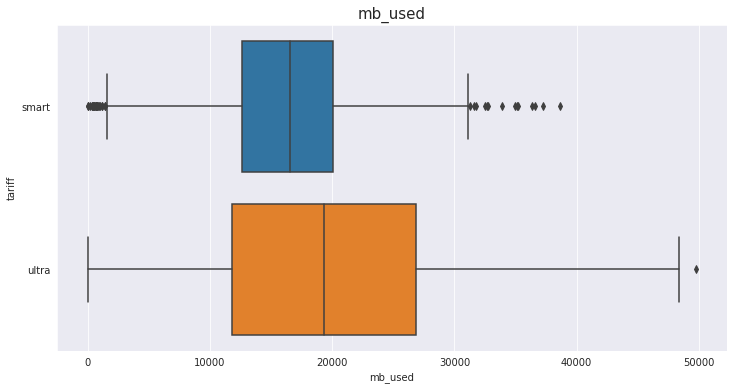

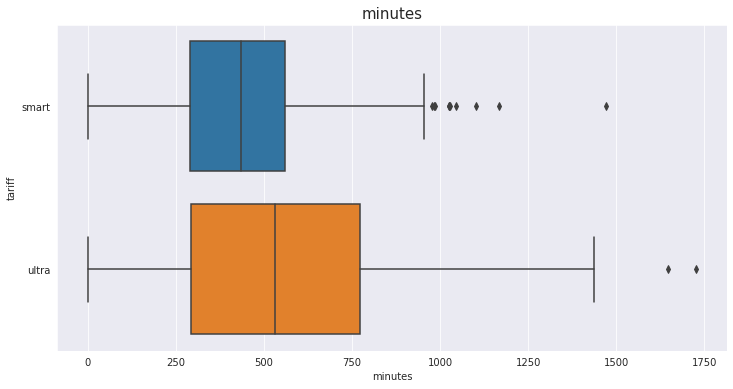

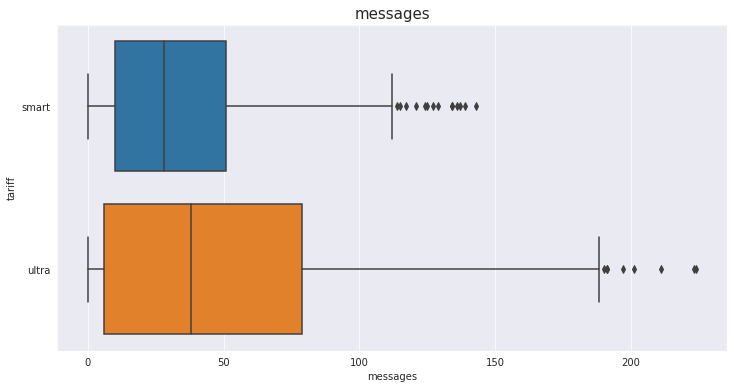

In [84]:
#Построим boxplot'ы с помощью цикла 
for columns in users_costs[['mb_used','minutes','messages']]:
    plt.figure(figsize=(12,6))
    plt.title(columns, fontsize=15)
    sns.boxplot(data=users_costs, x=columns, y='tariff')

Вывод по боксплотам: Минуты разговора, число сообщений и объем потраченного интернет-трафика по тарифу «Ультра» имеет большую дисперсию по сравнению с тарифом «Смарт», и медианы по вышеперечисленным признакам также смещены в большую сторону. Кроме того, выбросов в рамках более дешевого тарифа существенно больше.

**Вывод по графику:**
<br> * тариф "Смарт" - Пользователи на звонки за месяц тратят от 250 до 650 минут (в среднем 400 минут). Примерно от 8 минут до 22 минут в день, скачивают около 16000 мегабайт, отправляют примерно 33 сообщения. Среднее значение меньше медианы, значит перед нами нормальное распределение с небольшой отрицательной скошенностью. Около 30% людей не хватает 500 минут в тарифе;
<br> * тариф "Ультра" - Пользователи данного тарифа в осноном говорят от 250 до 900 минут (в среднем 500 минут). Это в разы меньше, чем предоставлено по тарифу, скачивают около 20000 мегабайт, отправляют примерно 49 сообщений. Нормальное распределение имеет положительную скошенность.

In [85]:
print('Пользователи тарифа Smart.')
print('Процент пользователей, превышающих лимит по минутам - {:.2%}'.format(
        smart_tariff['minutes'][smart_tariff['minutes'] > 500].shape[0]/smart_tariff['minutes'].shape[0]))
print('Процент пользователей, превышающих лимит по смс - {:.2%}'.format(
        smart_tariff['messages'][smart_tariff['messages'] > 50].shape[0]/smart_tariff['messages'].shape[0]))
print('Процент пользователей, превышающих лимит по МБ - {:.2%}'.format(
        smart_tariff['mb_used'][smart_tariff['mb_used'] > 15360].shape[0]/smart_tariff['mb_used'].shape[0]))
print('Процент пользователей, платящих больше абонентской платы - {:.2%}'.format(
        smart_tariff['rub_monthly_fee_total'][smart_tariff['rub_monthly_fee_total'] > 550].shape[0]/smart_tariff['rub_monthly_fee_total'].shape[0]))
print()
print('Пользователи тарифа Ultra.')
print('Процент пользователей, превышающих лимит по минутам - {:.2%}'.format(
        ultra_tariff['minutes'][ultra_tariff['minutes'] > 3000].shape[0]/ultra_tariff['minutes'].shape[0]))
print('Процент пользователей, превышающих лимит по смс - {:.2%}'.format(
        ultra_tariff['messages'][ultra_tariff['messages'] > 1000].shape[0]/ultra_tariff['messages'].shape[0]))
print('Процент пользователей, превышающих лимит по МБ - {:.2%}'.format(
        ultra_tariff['mb_used'][ultra_tariff['mb_used'] > 30720].shape[0]/ultra_tariff['mb_used'].shape[0]))
print('Процент пользователей, платящих больше абонентской платы - {:.2%}'.format(
        ultra_tariff['rub_monthly_fee_total'][ultra_tariff['rub_monthly_fee_total'] > 1950].shape[0]/ultra_tariff['rub_monthly_fee_total'].shape[0]))

Пользователи тарифа Smart.
Процент пользователей, превышающих лимит по минутам - 36.38%
Процент пользователей, превышающих лимит по смс - 25.30%
Процент пользователей, превышающих лимит по МБ - 58.73%
Процент пользователей, платящих больше абонентской платы - 75.15%

Пользователи тарифа Ultra.
Процент пользователей, превышающих лимит по минутам - 0.00%
Процент пользователей, превышающих лимит по смс - 0.00%
Процент пользователей, превышающих лимит по МБ - 13.60%
Процент пользователей, платящих больше абонентской платы - 13.60%


***Вывод по шагу 3.2:***
<br> * тариф "Смарт":
<br> Около 36.38% пользователей превышают данный пакетом лимит в 500 минут;
<br> Около 25.30% пользователям недостаточно 50 сообщений в месяц;
<br> Около 58.73% пользователей использую больше 15 ГБ трафика интернета в месяц;
<br> Процент пользователей, платящих больше абонентской платы составляет 75.15%, т.е. пользователи платят больше 550 рублей.
<br> Результатом использования сверх лимита является ситуация с большой оплатой за месяц. Рекордная 5252 рубля. Самой значимой затратой является пакет трафика на месяц. По гистограмме видны шаги в 200 рублей.
<br> * тариф "Ультра":
<br> пользователи не превышают лимиты по количеству минут и смс в месяц.
<br> Около 13.60% перерасходуют лимит по интернету. Получается плата за месяц выше только по причине интернета. Это видно по шагам в 150 рублей на гистограмме.
<br> Процент пользователей, платящих больше абонентской платы составляет 13.60%, т.е. большинству пользователей данного тарифа предоставленного пакета услуг хватает.

### Среднее количество минут разговора, количества сообщений и объёма интернет-трафика по Москве и другим регионам

In [86]:
moscow = users_costs['city'] == 'Москва'
users_costs['city'].where(moscow, 'Другой регион', inplace=True)

city_monthly_costs = users_costs.pivot_table(
    index=['city', 'month'],
    values=values
)

In [87]:
city_usage = city_monthly_costs.pivot_table(
    index='city',
    values=values
)
city_usage

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
city,,,,,
Другой регион,15676.051567,35.268458,424.594742,451.303353,1397.843400
Москва,17597.817342,33.944639,455.792652,388.257994,1483.223264


***Вывод по шагу 3.3:***
<br> * По средним значениям выручки пользователей Москвы и регионов мы видим разницу по столбцу "rub_monthly_fee_ove" (+ бесплатный пакет услуг) в 63 рубля в пользу регионов, по столбцу "rub_monthly_fee_total" (суммарная оплата услуг) в 85 рублей в пользу Москвы.
<br> * В Москве больше трафик интернета и длительность звонков больше. Сообщений больше оправляется с регионов.

## Шаг 4. Проверка гипотезы

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт»

<br> H₀: Средняя выручка пользователей тарифов "Ультра" и "Смарт" не различаются.
<br> H₁: Средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются.
<br> Пороговое значение alpha (критический уровень статистической значимости) зададим равным 5%.

In [88]:
alpha = 0.05 # критический уровень статистической значимости
             # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    smart_tariff['rub_monthly_fee_total'], 
    ultra_tariff['rub_monthly_fee_total'],equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.0842599087855396e-282
Отвергаем нулевую гипотезу


In [89]:
users_costs.pivot_table(index='tariff', values='rub_monthly_fee_total', aggfunc='median')

,rub_monthly_fee_total
tariff,
smart,986.492188
ultra,1950.000000


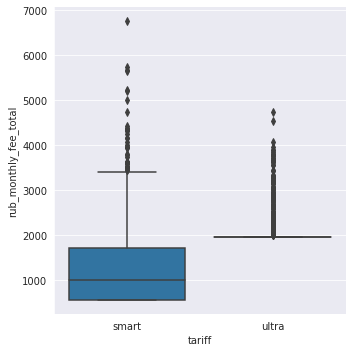

In [90]:
_ = sns.catplot(x="tariff", y='rub_monthly_fee_total', kind="box", data=users_costs, orient='v')

***Вывод по шагу 4.1:***
<br> Средние значения выручки по тарифам различаются в 1,98 раза. Если у пользователя подключен тариф "Смарт" с абонентской платой в 550 рублей, то он скорее всего по итогам месяца заплатит гораздо больше из-за нехватки услуг в рамках тарифного пакета.
<br> С уверенностью 99% можем предположить, что пользователи тарифа "Ультра" действительно отличаются по доходам от тарифа "Смарт".

### Cредняя выручка пользователей Москвы от выручки пользователей из других регионов

<br> H₀: Cредняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.
<br> H₁: Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
<br> Пороговое значение alpha (критический уровень статистической значимости) зададим равным 5%.

In [91]:
alpha = 0.05 # критический уровень статистической значимости
             # если p-value окажется меньше него - отвергнем гипотезу

moscow = users_costs.query("city == 'Москва'")['rub_monthly_fee_total']
other_cities = users_costs.query("city == 'Другой регион'")['rub_monthly_fee_total']

results = st.ttest_ind(moscow, other_cities, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5014487809585113
Не получилось отвергнуть нулевую гипотезу


In [92]:
def det_region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Другой регион'
    
users_costs['region'] = users_costs['city'].apply(det_region)
users_costs.pivot_table(index='region', values='rub_monthly_fee_total', aggfunc='median')

,rub_monthly_fee_total
region,
Другой регион,1544.335938
Москва,1730.273438


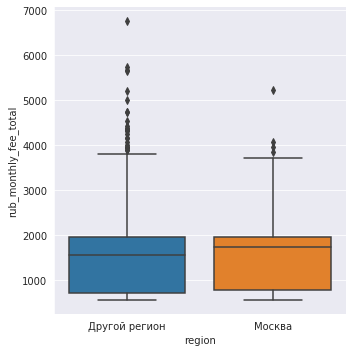

In [93]:
_ = sns.catplot(x="region", y='rub_monthly_fee_total', kind="box", data=users_costs, orient='v')

***Вывод по шагу 4.2:***
<br> Cредняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. Существует вероятность 50,3%  того, что я бы ошибся, если бы не отклонил нулевую гипотезу и сделал вывод, что доходы в Москве и регионах отличаются.

## Шаг 5. Общий вывод

***На основе выполненного анализа пришел к следующему выводу:
<br> * за 2018г клиентам двух тарифных планов, «Смарт» и «Ультра»,зафиксировано 500чел.(«Смарт» - 351, «Ультра» - 149);
<br> * Пользователи тарифа Ультра более активны почти по всем позициям (длительность звонков, количество сообщений и объём интернет-трафика), но пользователи тарифа Смарт тратят в 6 раз больше на дополнительные пакеты услуг.
<br> * Для оператора прибыльным тарифом является тариф Ультра, даже с учетом того, что в среднем пользователи не выходят за границы тарифных лимитов, а пользователи тарифа Смарт не тратят столько денег, чтобы перегнать стоимость тарифа Ультра. Таким образом, для пользователя выгоднее тариф Смарт.
<br> * Пользователи тарифа "Смарт" на звонки за месяц тратят от 250 до 650 минут. Примерно от 8 минут до 22 минут в день. Около 30% людей не хватает 500 минут в тарифе;
<br> * Пользователи тарифа "Ультра" в осноном говорят от 250 до 900 минут. Это в разы меньше, чем предоставлено по тарифу.
<br> * Пользователи тарифа "Смарт" отправляют до 50 сообщений в месяц (по 1-2 в день). Здесь заментна положительная скошенность нормального распределения;
<br> * Пользователи тарифа "Ультра" отправляют до 75 сообщений в месяц (по 2-3 в день), что в разы меньше предложенного в тарифе;
<br> * Пользователи тарифа "Смарт" в основном тратили от 12000 до 22000 МБ;
<br> * Пользователи тарифа "Ультра" в основном тратят от 9000 до 30000 МБ.
<br> * Пользователи тарифа "Смарт" около 36.37% пользователей превышают данный пакетом лимит в 500 минут.
Около 25.29% пользователям недостаточно 50 сообщений в месяц.
Около 58.74% пользователей использую больше 15 ГБ трафика интернета в месяц.
Результатом использования сверх лимита является ситуация с большой оплатой за месяц. Рекордная 5252 рубля. Самой значимой затратой является пакет трафика на месяц. По гистограмме видны шаги в 200 рублей. 75.16% пользователей платят больше 550 рублей;
<br> * Пользователи тарифа "Ультра" не превышают лимиты по количеству минут и смс в месяц.
Около 13.59% перерасходуют лимит по интернету. Получается плата за месяц выше только по причине интернета. Это видно по шагам в 150 рублей на гистограмме.
<br> * По средним значениям выручки пользователей Москвы и регионов мы видим разницу по столбцу "rub_monthly_fee_ove" (+ бесплатный пакет услуг) в 63 рубля в пользу регионов, по столбцу "rub_monthly_fee_total" (суммарная оплата услуг) в 85 рублей в пользу Москвы.
<br> * В Москве больше трафик интернета и длительность звонков больше. Сообщений болше оправляется с регионов.
<br> * Средняя выручка пользователей тарифов «Ультра» и «Смарт» дейтсвительно различаются.
<br> * Cредняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.
<br> * 200 для УЛЬТРА требуется сообщений в месяц.
<br> * 120 для СМАРТ требуется сообщений в месяц.
<br> * Тем самым для тарифа ультра можно уменьшить тарифный план, а для смарт увеличить.
<br> * 1550 для УЛЬТРА требуется минут разговора в месяц.
<br> * 1000 для СМАРТ требуется минут разговора в месяц.
<br> * 50 для УЛЬТРА требуется гб интернет трафика в месяц
<br> * 32 для СМАРТ требуется гб интернет трафика в месяц
<br> * Каждый пользователь тарифа Ультра приносит компании в среднем 13 622 рублей в год, пользователь тарифа Смарт приносит лишь 7940 рублей в год;
<br> * Годовая выручка компании по тарифу Смарт - 2 786 975 рублей в год, по тарифу Ультра приносит 2 029 622 рублей в год.
<br> * По проведенному анализу можно сделать вывод, что тариф "Ультра" является наиболее выгодным тарифом.***